# Benchmark PySpark vs PyThoth

## Generating Dataset

In [1]:
import random

small_list = [random.randint(1, 100) for _ in range(50)]
medium_list = [random.randint(1, 100) for _ in range(5_000)]
large_list = [random.randint(1, 100) for _ in range(500_000)]
extra_large_list = [random.randint(1, 100) for _ in range(5_000_000)]
print("Generating double extra large list...")
double_extra_large_list = [random.randint(1, 100) for _ in range(50_000_000)]
print("Finished generating double extra large list.")

Generating double extra large list...
Finished generating double extra large list.


# PySpark Benchmark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import time

In [8]:
#192.168.122.217    spark-master

MASTER_IP = "spark-master"


In [9]:

spark = (
    SparkSession.builder.appName("Thoth Benchmark")
    .master(f"spark://{MASTER_IP}:7077")
    # .config("spark.executor.memory", "1g")
    # .config("spark.driver.memory", "1g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/20 12:05:16 WARN Utils: Your hostname, akm, resolves to a loopback address: 127.0.1.1; using 192.168.1.5 instead (on interface enp3s0)
25/10/20 12:05:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/20 12:05:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Average Calculations

In [10]:
# Create DataFrames, this step takes a lot of time
small_df = spark.createDataFrame(small_list, "int").toDF("value")
medium_df = spark.createDataFrame(medium_list, "int").toDF("value")
large_df = spark.createDataFrame(large_list, "int").toDF("value")
extra_large_list_df = spark.createDataFrame(extra_large_list, "int").toDF("value")
double_extra_large_list_df = spark.createDataFrame(double_extra_large_list, "int").toDF("value")

In [11]:
def spark_avg(df, label):
    start_time = time.time()
    df.agg(avg("value")).show()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"\nSpark Time taken to process {label} DataFrame: {elapsed} seconds")
    return elapsed




In [6]:
py_spark_avg_small_list_time = spark_avg(small_df, "small")
py_spark_avg_medium_list_time = spark_avg(medium_df, "medium")
py_spark_avg_large_list_time = spark_avg(large_df, "large")
py_spark_avg_extra_large_list_time = spark_avg(extra_large_list_df, "extra large")
py_spark_avg_double_extra_large_list_time = spark_avg(double_extra_large_list_df, "double extra large")

+----------+
|avg(value)|
+----------+
|      53.2|
+----------+


Spark Time taken to process small DataFrame: 2.9491114616394043 seconds
+----------+
|avg(value)|
+----------+
|   50.5616|
+----------+


Spark Time taken to process medium DataFrame: 0.21814298629760742 seconds
+----------+
|avg(value)|
+----------+
| 50.447286|
+----------+


Spark Time taken to process large DataFrame: 0.4302253723144531 seconds


25/10/20 11:49:12 WARN TaskSetManager: Stage 9 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.
25/10/20 11:49:13 WARN TaskSetManager: Stage 12 contains a task of very large size (65558 KiB). The maximum recommended task size is 1000 KiB.


+----------+
|avg(value)|
+----------+
|50.5286812|
+----------+


Spark Time taken to process extra large DataFrame: 1.2518715858459473 seconds


+-----------+
| avg(value)|
+-----------+
|50.49710428|
+-----------+


Spark Time taken to process double extra large DataFrame: 8.691305160522461 seconds


### Min Max Calculations

In [12]:
from pyspark.sql.functions import min as spark_min, max as spark_max
def spark_min_max(df, label):
    # Min timing
    start_time = time.time()
    min_value = df.agg(spark_min("value").alias("min")).collect()[0]['min']
    end_time = time.time()
    min_time = end_time - start_time
    print(f"{label} List - Min: {min_value}")
    print(f"Spark Time taken for {label} min: {min_time} seconds")

    # Max timing
    start_time = time.time()
    max_value = df.agg(spark_max("value").alias("max")).collect()[0]['max']
    end_time = time.time()
    max_time = end_time - start_time
    print(f"{label} List - Max: {max_value}")
    print(f"Spark Time taken for {label} max: {max_time} seconds")

    return min_value, min_time, max_value, max_time



In [8]:

small_min, py_spark_small_min_time, small_max, py_spark_small_max_time = spark_min_max(small_df, "Small")
medium_min, py_spark_medium_min_time, medium_max, py_spark_medium_max_time = spark_min_max(medium_df, "Medium")
large_min, py_spark_large_min_time, large_max, py_spark_large_max_time = spark_min_max(large_df, "Large")
extra_large_min, py_spark_extra_large_min_time, extra_large_max, py_spark_extra_large_max_time = spark_min_max(extra_large_list_df, "Extra Large")
double_extra_large_min, py_spark_double_extra_large_min_time, double_extra_large_max, py_spark_double_extra_large_max_time = spark_min_max(double_extra_large_list_df, "Double Extra Large")

Small List - Min: 1
Spark Time taken for Small min: 0.32195115089416504 seconds
Small List - Max: 91
Spark Time taken for Small max: 0.22890233993530273 seconds
Medium List - Min: 1
Spark Time taken for Medium min: 0.19403934478759766 seconds
Medium List - Max: 100
Spark Time taken for Medium max: 0.18384861946105957 seconds
Large List - Min: 1
Spark Time taken for Large min: 0.21807646751403809 seconds
Large List - Max: 100
Spark Time taken for Large max: 0.23667526245117188 seconds


25/10/20 11:49:23 WARN TaskSetManager: Stage 33 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.
25/10/20 11:49:24 WARN TaskSetManager: Stage 36 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Min: 1
Spark Time taken for Extra Large min: 0.9238808155059814 seconds


25/10/20 11:49:25 WARN TaskSetManager: Stage 39 contains a task of very large size (65558 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Max: 100
Spark Time taken for Extra Large max: 0.9914193153381348 seconds


Double Extra Large List - Min: 1
Spark Time taken for Double Extra Large min: 7.736701250076294 seconds


25/10/20 11:49:33 WARN TaskSetManager: Stage 42 contains a task of very large size (65558 KiB). The maximum recommended task size is 1000 KiB.


Double Extra Large List - Max: 100
Spark Time taken for Double Extra Large max: 7.627714157104492 seconds


### Sorting Calculations

In [13]:
from pyspark.sql.functions import asc
def spark_sort_asc(df, label):
    start_time = time.time()
    sorted_df = df.orderBy(asc("value"))
    sorted_df.show()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Spark Time taken to sort {label} list ascending: {elapsed} seconds")
    return sorted_df, elapsed


In [ ]:

small_sorted_asc, py_spark_small_sort_asc_time = spark_sort_asc(small_df, "small")
medium_sorted_asc, py_spark_medium_sort_asc_time = spark_sort_asc(medium_df, "medium")
large_sorted_asc, py_spark_large_sort_asc_time = spark_sort_asc(large_df, "large")
extra_large_sorted_asc, py_spark_extra_large_sort_asc_time = spark_sort_asc(extra_large_list_df, "extra large")
double_extra_large_sorted_asc, py_spark_double_extra_large_sort_asc_time = spark_sort_asc(double_extra_large_list_df, "double extra large")

+-----+
|value|
+-----+
|    1|
|    3|
|    7|
|   10|
|   11|
|   13|
|   14|
|   14|
|   18|
|   18|
|   22|
|   24|
|   26|
|   37|
|   37|
|   38|
|   41|
|   44|
|   46|
|   49|
+-----+
only showing top 20 rows
Spark Time taken to sort small list ascending: 0.31431150436401367 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort medium list ascending: 0.1356678009033203 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort large list ascending: 0.229079008102417 seconds


25/10/20 11:49:41 WARN TaskSetManager: Stage 48 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.
25/10/20 11:49:42 WARN TaskSetManager: Stage 49 contains a task of very large size (65558 KiB). The maximum recommended task size is 1000 KiB.


+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort extra large list ascending: 1.0486023426055908 seconds


+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort double extra large list ascending: 9.33036184310913 seconds


25/10/20 11:50:00 ERROR TaskSchedulerImpl: Lost executor 0 on 192.168.122.215: Command exited with code 143
25/10/20 11:50:03 WARN StandaloneAppClient$ClientEndpoint: Connection to 192.168.122.217:7077 failed; waiting for master to reconnect...
25/10/20 11:50:03 WARN StandaloneSchedulerBackend: Disconnected from Spark cluster! Waiting for reconnection...


# Thoth BenchMark

In [14]:
from py_thoth.operations.vector import list_average
from py_thoth.settings.connections import change_remote_address
remote_addresses = ["192.168.122.217:50051", "192.168.122.215:50051"]
change_remote_address(remote_addresses)


Remote address changed to: ['192.168.122.217:50051', '192.168.122.215:50051']


### Average Calculations

In [15]:
def thoth_avg_benchmark(lst, label):
    start_time = time.time()
    avg_value = list_average(lst)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Average {label} List: {avg_value}")
    print(f"\nThoth {label} List Time taken: {elapsed} seconds")
    return elapsed



In [13]:

thoth_small_list_time = thoth_avg_benchmark(small_list, "Small")
thoth_medium_list_time = thoth_avg_benchmark(medium_list, "Medium")
thoth_large_list_time = thoth_avg_benchmark(large_list, "Large")
thoth_extra_large_list_time = thoth_avg_benchmark(extra_large_list, "Extra Large")
thoth_double_extra_large_list_time = thoth_avg_benchmark(double_extra_large_list, "Double Extra Large")

Average Small List: 53.2

Thoth Small List Time taken: 0.030953645706176758 seconds
Average Medium List: 50.5616

Thoth Medium List Time taken: 0.013035058975219727 seconds
Average Large List: 50.447286

Thoth Large List Time taken: 0.13045263290405273 seconds
Average Extra Large List: 50.5286812

Thoth Extra Large List Time taken: 1.4056918621063232 seconds
Average Double Extra Large List: 50.49710428

Thoth Double Extra Large List Time taken: 19.77864694595337 seconds


### Min Max, Sorting Calculations

In [35]:
from py_thoth.operations.vector import sort_list, max_list, min_list
def thoth_min_benchmark(lst, label):
    start_time = time.time()
    min_value = min_list(lst)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"{label} List - Min (Thoth): {min_value}")
    print(f"Thoth Time taken for {label} min: {elapsed} seconds")
    return min_value, elapsed

In [15]:
thoth_small_min, thoth_small_min_time = thoth_min_benchmark(small_list, "Small")
thoth_medium_min, thoth_medium_min_time = thoth_min_benchmark(medium_list, "Medium")
thoth_large_min, thoth_large_min_time = thoth_min_benchmark(large_list, "Large")
thoth_extra_large_min, thoth_extra_large_min_time = thoth_min_benchmark(extra_large_list, "Extra Large")
thoth_double_extra_large_min, thoth_double_extra_large_min_time = thoth_min_benchmark(double_extra_large_list, "Double Extra Large")

Small List - Min (Thoth): 1.0
Thoth Time taken for Small min: 0.012153863906860352 seconds
Medium List - Min (Thoth): 1.0
Thoth Time taken for Medium min: 0.007211446762084961 seconds
Large List - Min (Thoth): 1.0
Thoth Time taken for Large min: 0.11238956451416016 seconds
Extra Large List - Min (Thoth): 1.0
Thoth Time taken for Extra Large min: 1.4179577827453613 seconds
Double Extra Large List - Min (Thoth): 1.0
Thoth Time taken for Double Extra Large min: 17.244606971740723 seconds


In [37]:
def thoth_max_benchmark(lst, label):
    start_time = time.time()
    max_value = max_list(lst)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"{label} List - Max (Thoth): {max_value}")
    print(f"Thoth Time taken for {label} max: {elapsed} seconds")
    return max_value, elapsed


In [17]:

thoth_small_max, thoth_small_max_time = thoth_max_benchmark(small_list, "Small")
thoth_medium_max, thoth_medium_max_time = thoth_max_benchmark(medium_list, "Medium")
thoth_large_max, thoth_large_max_time = thoth_max_benchmark(large_list, "Large")
thoth_extra_large_max, thoth_extra_large_max_time = thoth_max_benchmark(extra_large_list, "Extra Large")
thoth_double_extra_large_max, thoth_double_extra_large_max_time = thoth_max_benchmark(double_extra_large_list, "Double Extra Large")

Small List - Max (Thoth): 91.0
Thoth Time taken for Small max: 0.013364791870117188 seconds
Medium List - Max (Thoth): 100.0
Thoth Time taken for Medium max: 0.008868694305419922 seconds
Large List - Max (Thoth): 100.0
Thoth Time taken for Large max: 0.11266279220581055 seconds
Extra Large List - Max (Thoth): 100.0
Thoth Time taken for Extra Large max: 1.343895673751831 seconds
Double Extra Large List - Max (Thoth): 100.0
Thoth Time taken for Double Extra Large max: 18.576628923416138 seconds


In [36]:
def thoth_sort_asc_benchmark(lst, label):
    start_time = time.time()
    sorted_lst = sort_list(lst, ascending=True)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"{label} List - Sorted Ascending (Thoth): {sorted_lst[:10]} ...")
    print(f"Thoth Time taken to sort {label} list ascending: {elapsed} seconds")
    return sorted_lst, elapsed



In [19]:

thoth_small_sorted_asc, thoth_small_sort_asc_time = thoth_sort_asc_benchmark(small_list, "Small")
thoth_medium_sorted_asc, thoth_medium_sort_asc_time = thoth_sort_asc_benchmark(medium_list, "Medium")
thoth_large_sorted_asc, thoth_large_sort_asc_time = thoth_sort_asc_benchmark(large_list, "Large")
thoth_extra_large_sorted_asc, thoth_extra_large_sort_asc_time = thoth_sort_asc_benchmark(extra_large_list, "Extra Large")
thoth_double_extra_large_sorted_asc, thoth_double_extra_large_sort_asc_time = thoth_sort_asc_benchmark(double_extra_large_list, "Double Extra Large")

Small List - Sorted Ascending (Thoth): [1.0, 3.0, 7.0, 10.0, 11.0, 14.0, 18.0, 22.0, 24.0, 37.0] ...
Thoth Time taken to sort Small list ascending: 0.04224586486816406 seconds
Medium List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Medium list ascending: 0.05745673179626465 seconds
Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Large list ascending: 0.5559792518615723 seconds
Extra Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Extra Large list ascending: 1.9191768169403076 seconds
Double Extra Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Double Extra Large list ascending: 27.748458862304688 seconds


### Plotting Results

In [38]:
import pandas as pd
def create_comparison_df():
    comparison_data = {
        "Dataset": [
            f"Small ({len(small_list):,})",
            f"Medium ({len(medium_list):,})",
            f"Large ({len(large_list):,})",
            f"Extra Large ({len(extra_large_list):,})",
            f"Double Extra Large ({len(double_extra_large_list):,})"
        ],
        "Thoth Avg Time (s)": [
            thoth_small_list_time,
            thoth_medium_list_time,
            thoth_large_list_time,
            thoth_extra_large_list_time,
            thoth_double_extra_large_list_time
        ],
        "PySpark Avg Time (s)": [
            py_spark_avg_small_list_time,
            py_spark_avg_medium_list_time,
            py_spark_avg_large_list_time,
            py_spark_avg_extra_large_list_time,
            py_spark_avg_double_extra_large_list_time
        ],
        "Thoth Min Time (s)": [
            thoth_small_min_time,
            thoth_medium_min_time,
            thoth_large_min_time,
            thoth_extra_large_min_time,
            thoth_double_extra_large_min_time
        ],
        "PySpark Min Time (s)": [
            py_spark_small_min_time,
            py_spark_medium_min_time,
            py_spark_large_min_time,
            py_spark_extra_large_min_time,
            py_spark_double_extra_large_min_time
        ],
        "Thoth Max Time (s)": [
            thoth_small_max_time,
            thoth_medium_max_time,
            thoth_large_max_time,
            thoth_extra_large_max_time,
            thoth_double_extra_large_max_time
        ],
        "PySpark Max Time (s)": [
            py_spark_small_max_time,
            py_spark_medium_max_time,
            py_spark_large_max_time,
            py_spark_extra_large_max_time,
            py_spark_double_extra_large_max_time
        ],
        "Thoth Sort Asc Time (s)": [
            thoth_small_sort_asc_time,
            thoth_medium_sort_asc_time,
            thoth_large_sort_asc_time,
            thoth_extra_large_sort_asc_time,
            thoth_double_extra_large_sort_asc_time
        ],
        "PySpark Sort Asc Time (s)": [
            py_spark_small_sort_asc_time,
            py_spark_medium_sort_asc_time,
            py_spark_large_sort_asc_time,
            py_spark_extra_large_sort_asc_time,
            py_spark_double_extra_large_sort_asc_time
        ]
    }
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.head())
    return df_comparison



In [21]:
df_comparison = create_comparison_df()

                           Dataset  Thoth Avg Time (s)  PySpark Avg Time (s)  \
0                       Small (50)            0.030954              2.949111   
1                   Medium (5,000)            0.013035              0.218143   
2                  Large (500,000)            0.130453              0.430225   
3          Extra Large (5,000,000)            1.405692              1.251872   
4  Double Extra Large (50,000,000)           19.778647              8.691305   

   Thoth Min Time (s)  PySpark Min Time (s)  Thoth Max Time (s)  \
0            0.012154              0.321951            0.013365   
1            0.007211              0.194039            0.008869   
2            0.112390              0.218076            0.112663   
3            1.417958              0.923881            1.343896   
4           17.244607              7.736701           18.576629   

   PySpark Max Time (s)  Thoth Sort Asc Time (s)  PySpark Sort Asc Time (s)  
0              0.228902               

In [ ]:
import os

OUTPUT_DIR = os.path.join("assets","benchmarks")
df_comparison.to_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_two_machines.csv"), index=False) 

In [21]:
import numpy as np

import matplotlib.pyplot as plt
def plot_benchmark_comparison(df_comparison, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    datasets = df_comparison["Dataset"]
    x = np.arange(len(datasets))  # the label locations
    width = 0.35  # the width of the bars
    # 1. Average Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Avg Time (s)"], width, label='Thoth', color='skyblue')
    plt.bar(x + width/2, df_comparison["PySpark Avg Time (s)"], width, label='PySpark', color='salmon')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Average Calculation Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "avg_time_comparison.png"))
    plt.show()

    # 2. Min Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Min Time (s)"], width, label='Thoth', color='orange')
    plt.bar(x + width/2, df_comparison["PySpark Min Time (s)"], width, label='PySpark', color='lightgreen')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Min Calculation Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "min_time_comparison.png"))
    plt.show()

    # 3. Max Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Max Time (s)"], width, label='Thoth', color='orange')
    plt.bar(x + width/2, df_comparison["PySpark Max Time (s)"], width, label='PySpark', color='lightgreen')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Max Calculation Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "max_time_comparison.png"))
    plt.show()

    # 4. Sort Ascending Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Sort Asc Time (s)"], width, label='Thoth', color='purple')
    plt.bar(x + width/2, df_comparison["PySpark Sort Asc Time (s)"], width, label='PySpark', color='gray')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Sort Ascending Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "sort_asc_time_comparison.png"))
    plt.show()


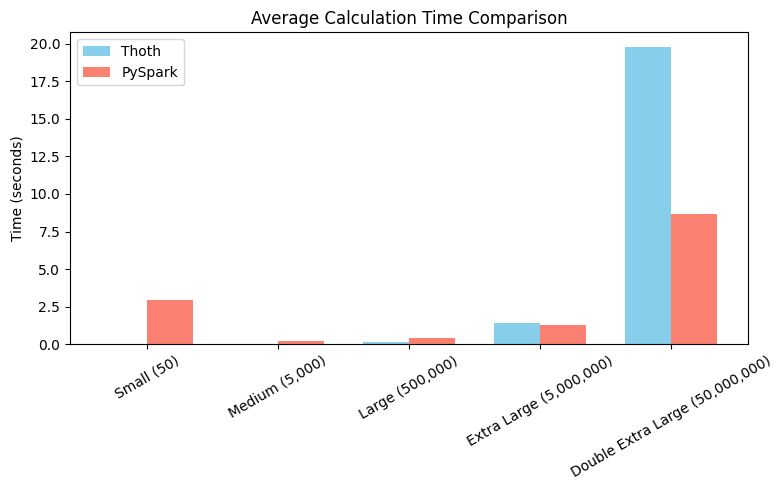

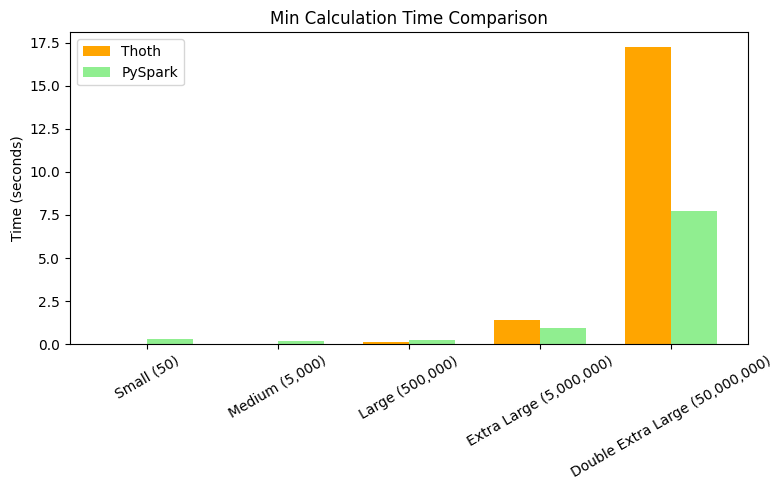

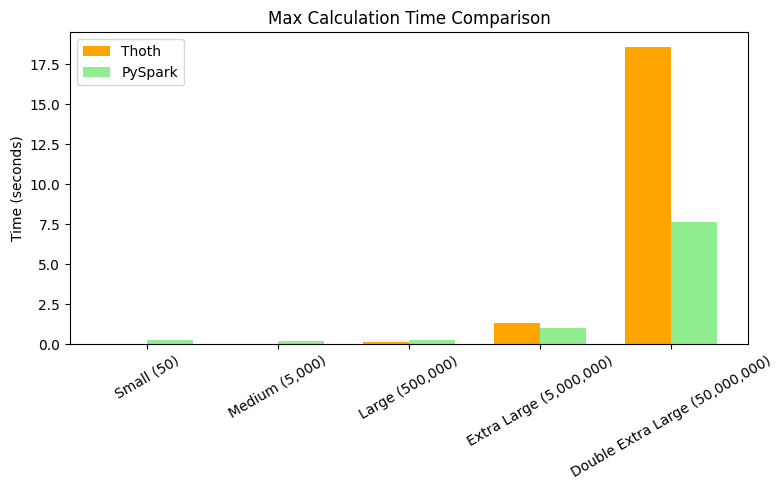

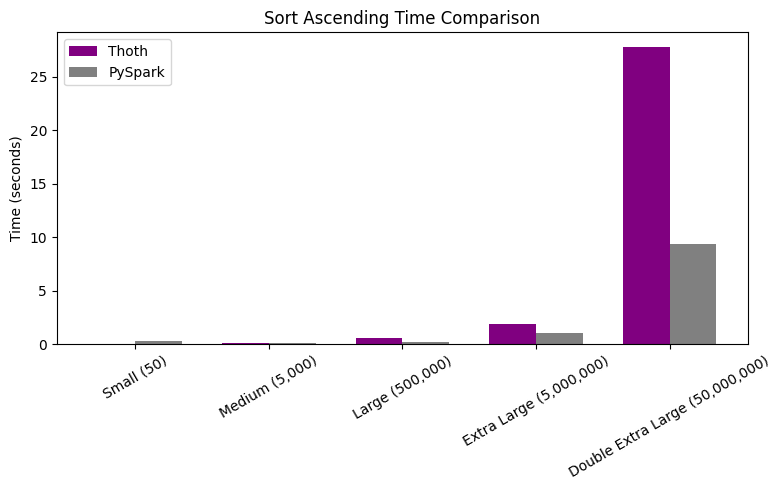

In [24]:

# Call the function
plot_benchmark_comparison(df_comparison, os.path.join(OUTPUT_DIR,"two_machines"))

## Three Machines

### Spark

In [22]:
spark = (
    SparkSession.builder.appName("Thoth Benchmark")
    .master(f"spark://{MASTER_IP}:7077")
    .getOrCreate()
)

In [23]:
py_spark_avg_small_list_time = spark_avg(small_df, "small")
py_spark_avg_medium_list_time = spark_avg(medium_df, "medium")
py_spark_avg_large_list_time = spark_avg(large_df, "large")
py_spark_avg_extra_large_list_time = spark_avg(extra_large_list_df, "extra large")
print("Finished benchmarking extra large list.")
py_spark_avg_double_extra_large_list_time = spark_avg(double_extra_large_list_df, "double extra large")

+----------+
|avg(value)|
+----------+
|     60.44|
+----------+


Spark Time taken to process small DataFrame: 2.8652660846710205 seconds
+----------+
|avg(value)|
+----------+
|    50.622|
+----------+


Spark Time taken to process medium DataFrame: 0.274613618850708 seconds
+----------+
|avg(value)|
+----------+
| 50.486118|
+----------+


Spark Time taken to process large DataFrame: 0.48032689094543457 seconds


25/10/20 12:06:17 WARN TaskSetManager: Stage 9 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.
25/10/20 12:06:18 WARN TaskSetManager: Stage 12 contains a task of very large size (32783 KiB). The maximum recommended task size is 1000 KiB.


+----------+
|avg(value)|
+----------+
|50.4850414|
+----------+


Spark Time taken to process extra large DataFrame: 0.8116014003753662 seconds
Finished benchmarking extra large list.


+-----------+
| avg(value)|
+-----------+
|50.49893896|
+-----------+


Spark Time taken to process double extra large DataFrame: 4.455915212631226 seconds


In [24]:
small_min, py_spark_small_min_time, small_max, py_spark_small_max_time = spark_min_max(small_df, "Small")
medium_min, py_spark_medium_min_time, medium_max, py_spark_medium_max_time = spark_min_max(medium_df, "Medium")
large_min, py_spark_large_min_time, large_max, py_spark_large_max_time = spark_min_max(large_df, "Large")
extra_large_min, py_spark_extra_large_min_time, extra_large_max, py_spark_extra_large_max_time = spark_min_max(extra_large_list_df, "Extra Large")
print("Finished benchmarking extra large list for min/max.")
double_extra_large_min, py_spark_double_extra_large_min_time, double_extra_large_max, py_spark_double_extra_large_max_time = spark_min_max(double_extra_large_list_df, "Double Extra Large")

Small List - Min: 7
Spark Time taken for Small min: 0.286466121673584 seconds
Small List - Max: 99
Spark Time taken for Small max: 0.2604207992553711 seconds
Medium List - Min: 1
Spark Time taken for Medium min: 0.22389984130859375 seconds
Medium List - Max: 100
Spark Time taken for Medium max: 0.2085721492767334 seconds
Large List - Min: 1
Spark Time taken for Large min: 0.20406341552734375 seconds
Large List - Max: 100
Spark Time taken for Large max: 0.23968791961669922 seconds


25/10/20 12:06:24 WARN TaskSetManager: Stage 33 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Min: 1
Spark Time taken for Extra Large min: 0.646242618560791 seconds


25/10/20 12:06:25 WARN TaskSetManager: Stage 36 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.
25/10/20 12:06:25 WARN TaskSetManager: Stage 39 contains a task of very large size (32783 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Max: 100
Spark Time taken for Extra Large max: 0.6544489860534668 seconds
Finished benchmarking extra large list for min/max.


25/10/20 12:06:30 WARN TaskSetManager: Stage 42 contains a task of very large size (32783 KiB). The maximum recommended task size is 1000 KiB.


Double Extra Large List - Min: 1
Spark Time taken for Double Extra Large min: 4.878843545913696 seconds


Double Extra Large List - Max: 100
Spark Time taken for Double Extra Large max: 4.650538921356201 seconds


In [25]:
small_sorted_asc, py_spark_small_sort_asc_time = spark_sort_asc(small_df, "small")
medium_sorted_asc, py_spark_medium_sort_asc_time = spark_sort_asc(medium_df, "medium")
large_sorted_asc, py_spark_large_sort_asc_time = spark_sort_asc(large_df, "large")
extra_large_sorted_asc, py_spark_extra_large_sort_asc_time = spark_sort_asc(extra_large_list_df, "extra large")
print("Finished benchmarking extra large list for sorting.")
double_extra_large_sorted_asc, py_spark_double_extra_large_sort_asc_time = spark_sort_asc(double_extra_large_list_df, "double extra large")

+-----+
|value|
+-----+
|    7|
|    8|
|   12|
|   14|
|   16|
|   18|
|   24|
|   27|
|   29|
|   29|
|   33|
|   38|
|   38|
|   46|
|   51|
|   52|
|   52|
|   53|
|   56|
|   56|
+-----+
only showing top 20 rows
Spark Time taken to sort small list ascending: 0.31428027153015137 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort medium list ascending: 0.1346747875213623 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort large list ascending: 0.18847918510437012 seconds


25/10/20 12:06:36 WARN TaskSetManager: Stage 48 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.
25/10/20 12:06:36 WARN TaskSetManager: Stage 49 contains a task of very large size (32783 KiB). The maximum recommended task size is 1000 KiB.


+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort extra large list ascending: 0.6725292205810547 seconds
Finished benchmarking extra large list for sorting.


+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort double extra large list ascending: 4.520212888717651 seconds


### Thoth

In [27]:
remote_addresses = ["192.168.122.217:50051", "192.168.122.215:50051", "192.168.122.33:50051"]

change_remote_address(remote_addresses)


Remote address changed to: ['192.168.122.217:50051', '192.168.122.215:50051', '192.168.122.33:50051']


In [28]:
thoth_small_list_time = thoth_avg_benchmark(small_list, "Small")
thoth_medium_list_time = thoth_avg_benchmark(medium_list, "Medium")
thoth_large_list_time = thoth_avg_benchmark(large_list, "Large")
thoth_extra_large_list_time = thoth_avg_benchmark(extra_large_list, "Extra Large")
print("Finished benchmarking extra large list.")
thoth_double_extra_large_list_time = thoth_avg_benchmark(double_extra_large_list, "Double Extra Large")

Average Small List: 60.44

Thoth Small List Time taken: 0.03248453140258789 seconds
Average Medium List: 50.622

Thoth Medium List Time taken: 0.0347440242767334 seconds
Average Large List: 50.486118

Thoth Large List Time taken: 0.10288429260253906 seconds
Average Extra Large List: 50.4850414

Thoth Extra Large List Time taken: 1.2780115604400635 seconds
Finished benchmarking extra large list.
Average Double Extra Large List: 50.49893896

Thoth Double Extra Large List Time taken: 23.302112102508545 seconds


In [29]:
thoth_small_min, thoth_small_min_time = thoth_min_benchmark(small_list, "Small")
thoth_medium_min, thoth_medium_min_time = thoth_min_benchmark(medium_list, "Medium")
thoth_large_min, thoth_large_min_time = thoth_min_benchmark(large_list, "Large")
thoth_extra_large_min, thoth_extra_large_min_time = thoth_min_benchmark(extra_large_list, "Extra Large")
print("Finished benchmarking extra large list for min.")
thoth_double_extra_large_min, thoth_double_extra_large_min_time = thoth_min_benchmark(double_extra_large_list, "Double Extra Large")


Small List - Min (Thoth): 7.0
Thoth Time taken for Small min: 0.004669904708862305 seconds
Medium List - Min (Thoth): 1.0
Thoth Time taken for Medium min: 0.20376968383789062 seconds
Large List - Min (Thoth): 1.0
Thoth Time taken for Large min: 0.0821986198425293 seconds
Extra Large List - Min (Thoth): 1.0
Thoth Time taken for Extra Large min: 0.7316420078277588 seconds
Finished benchmarking extra large list for min.
Double Extra Large List - Min (Thoth): 1.0
Thoth Time taken for Double Extra Large min: 11.04018259048462 seconds


In [39]:
thoth_small_max, thoth_small_max_time = thoth_max_benchmark(small_list, "Small")
thoth_medium_max, thoth_medium_max_time = thoth_max_benchmark(medium_list, "Medium")
thoth_large_max, thoth_large_max_time = thoth_max_benchmark(large_list, "Large")
thoth_extra_large_max, thoth_extra_large_max_time = thoth_max_benchmark(extra_large_list, "Extra Large")
print("Finished benchmarking extra large list for max.")
thoth_double_extra_large_max, thoth_double_extra_large_max_time = thoth_max_benchmark(double_extra_large_list, "Double Extra Large")


Small List - Max (Thoth): 99.0
Thoth Time taken for Small max: 0.006089448928833008 seconds
Medium List - Max (Thoth): 100.0
Thoth Time taken for Medium max: 0.003767728805541992 seconds
Large List - Max (Thoth): 100.0
Thoth Time taken for Large max: 0.1329820156097412 seconds
Extra Large List - Max (Thoth): 100.0
Thoth Time taken for Extra Large max: 1.12857985496521 seconds
Finished benchmarking extra large list for max.
Double Extra Large List - Max (Thoth): 100.0
Thoth Time taken for Double Extra Large max: 17.686399459838867 seconds


In [ ]:
thoth_small_sorted_asc, thoth_small_sort_asc_time = thoth_sort_asc_benchmark(small_list, "Small")
thoth_medium_sorted_asc, thoth_medium_sort_asc_time = thoth_sort_asc_benchmark(medium_list, "Medium")
thoth_large_sorted_asc, thoth_large_sort_asc_time = thoth_sort_asc_benchmark(large_list, "Large")
thoth_extra_large_sorted_asc, thoth_extra_large_sort_asc_time = thoth_sort_asc_benchmark(extra_large_list, "Extra Large")
print("Finished benchmarking extra large list for sorting.")
thoth_double_extra_large_sorted_asc, thoth_double_extra_large_sort_asc_time = thoth_sort_asc_benchmark(double_extra_large_list, "Double Extra Large")

Small List - Sorted Ascending (Thoth): [7.0, 8.0, 12.0, 14.0, 16.0, 18.0, 33.0, 53.0, 56.0, 57.0] ...
Thoth Time taken to sort Small list ascending: 2.727266550064087 seconds
Medium List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Medium list ascending: 0.009352684020996094 seconds
Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Large list ascending: 0.226273775100708 seconds


## Plotting Results

In [ ]:
df_comparison = create_comparison_df()
df_comparison.to_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_three_machines.csv"), index=False) 


                   Dataset  Thoth Avg Time (s)  PySpark Avg Time (s)  \
0               Small (50)            0.024280              2.955790   
1           Medium (5,000)            0.011146              0.387253   
2          Large (500,000)            0.080144              0.339128   
3  Extra Large (5,000,000)            1.094292              0.970658   

   Thoth Min Time (s)  PySpark Min Time (s)  Thoth Max Time (s)  \
0            0.006826              0.274783            0.059175   
1            0.029173              0.187578            0.003727   
2            0.066471              0.216383            0.059748   
3            1.031306              0.599354            0.730663   

   PySpark Max Time (s)  Thoth Sort Asc Time (s)  PySpark Sort Asc Time (s)  
0              0.222539                 0.003242                   0.266393  
1              0.195797                 0.007237                   0.162192  
2              0.289676                 0.202502                   0.

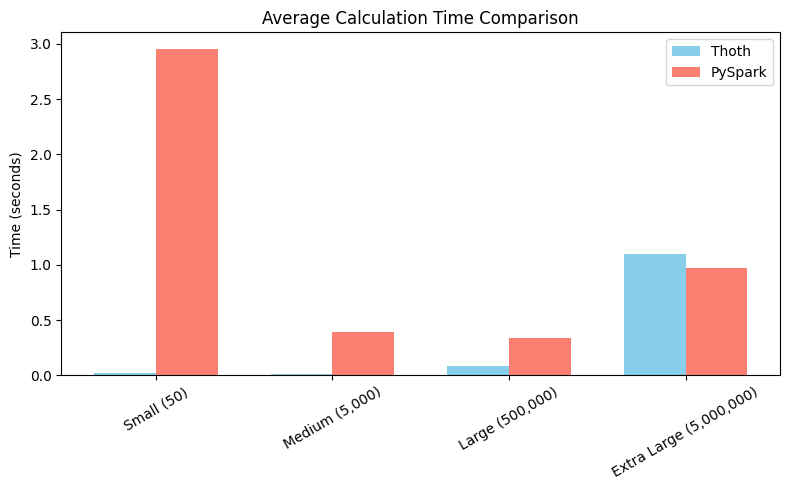

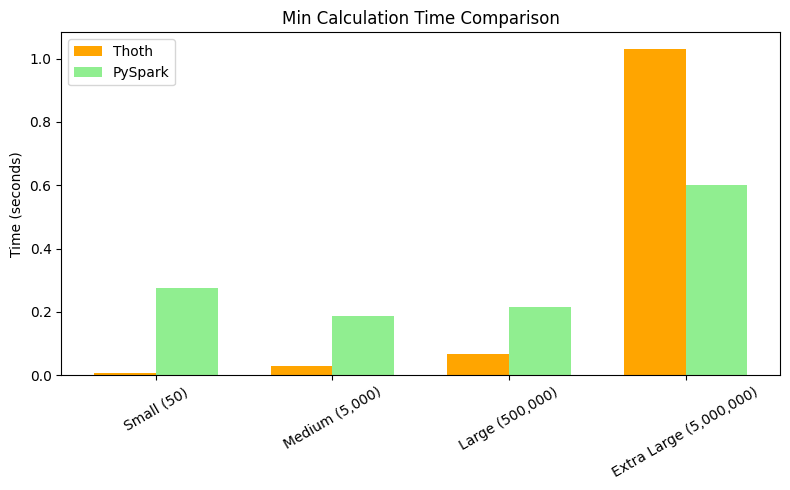

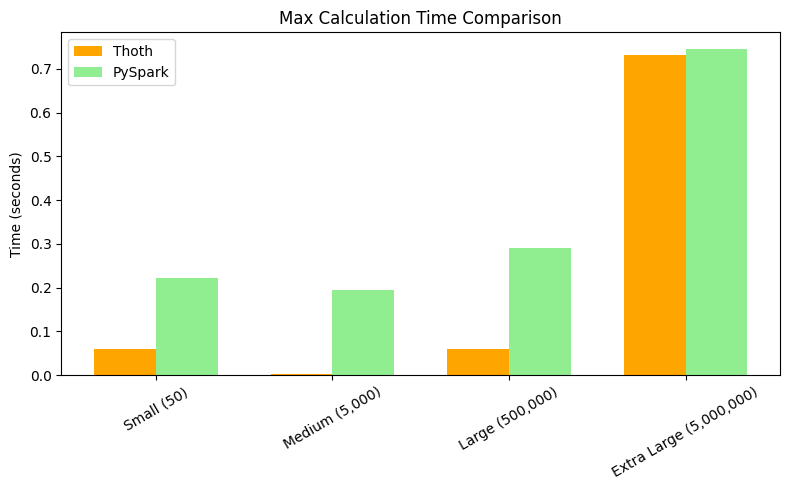

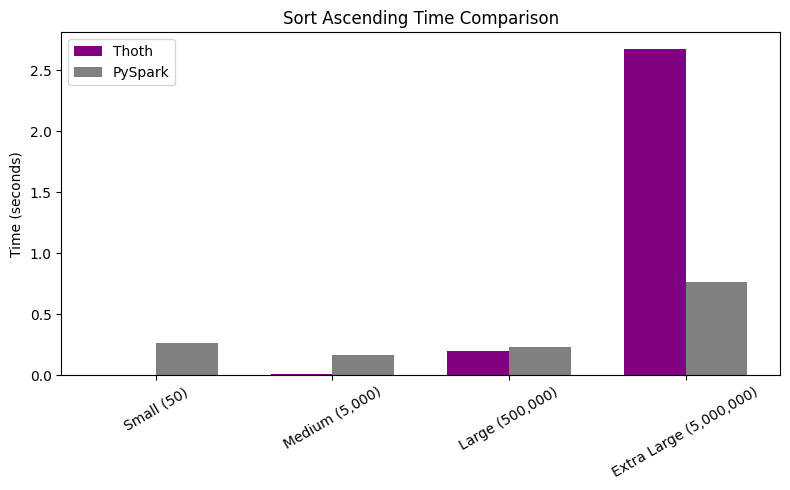

In [ ]:
plot_benchmark_comparison(df_comparison, os.path.join(OUTPUT_DIR,"three_machines"))

# General Plots

In [ ]:

two_machines_df = pd.read_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_two_machines.csv"))
three_machines_df = pd.read_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_three_machines.csv"))

In [ ]:
two_machines_df.head()

,Dataset,Thoth Avg Time (s),PySpark Avg Time (s),Thoth Min Time (s),PySpark Min Time (s),Thoth Max Time (s),PySpark Max Time (s),Thoth Sort Asc Time (s),PySpark Sort Asc Time (s)
0,Small (50),0.030954,2.949111,0.012154,0.321951,0.013365,0.228902,0.042246,0.314312
1,"Medium (5,000)",0.013035,0.218143,0.007211,0.194039,0.008869,0.183849,0.057457,0.135668
2,"Large (500,000)",0.130453,0.430225,0.112390,0.218076,0.112663,0.236675,0.555979,0.229079
3,"Extra Large (5,000,000)",1.405692,1.251872,1.417958,0.923881,1.343896,0.991419,1.919177,1.048602
4,"Double Extra Large (50,000,000)",19.778647,8.691305,17.244607,7.736701,18.576629,7.627714,27.748459,9.330362


In [ ]:
three_machines_df.head()

,Dataset,Thoth Avg Time (s),PySpark Avg Time (s),Thoth Min Time (s),PySpark Min Time (s),Thoth Max Time (s),PySpark Max Time (s),Thoth Sort Asc Time (s),PySpark Sort Asc Time (s)
0,Small (50),0.024280,2.955790,0.006826,0.274783,0.059175,0.222539,0.003242,0.266393
1,"Medium (5,000)",0.011146,0.387253,0.029173,0.187578,0.003727,0.195797,0.007237,0.162192
2,"Large (500,000)",0.080144,0.339128,0.066471,0.216383,0.059748,0.289676,0.202502,0.235088
3,"Extra Large (5,000,000)",1.094292,0.970658,1.031306,0.599354,0.730663,0.746000,2.677310,0.768711


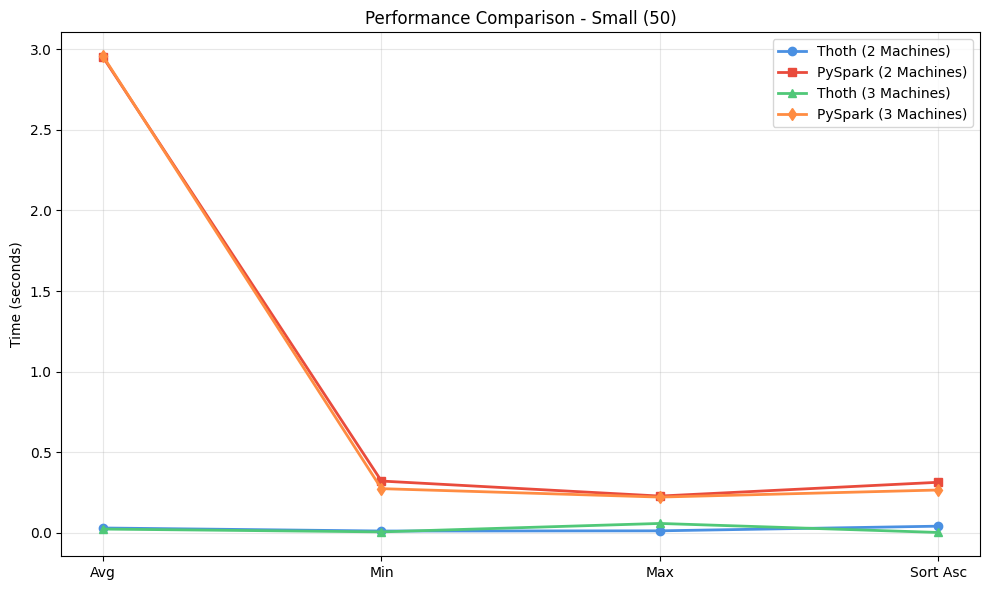

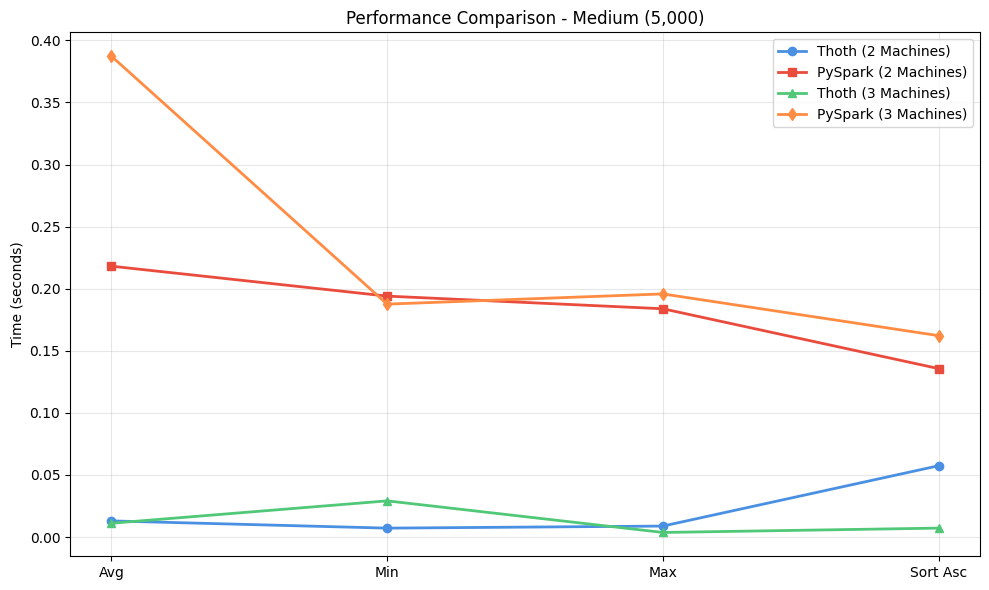

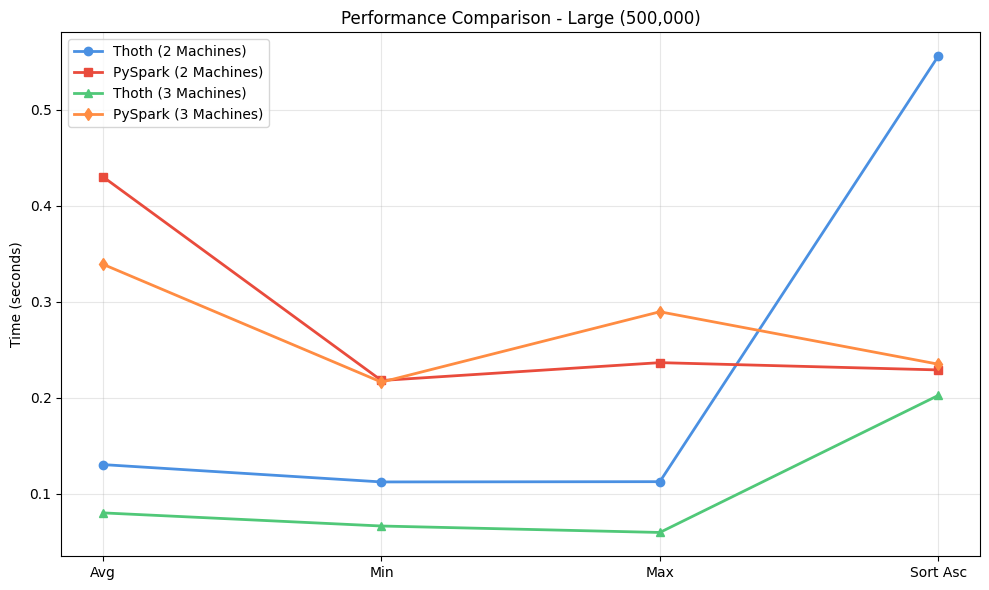

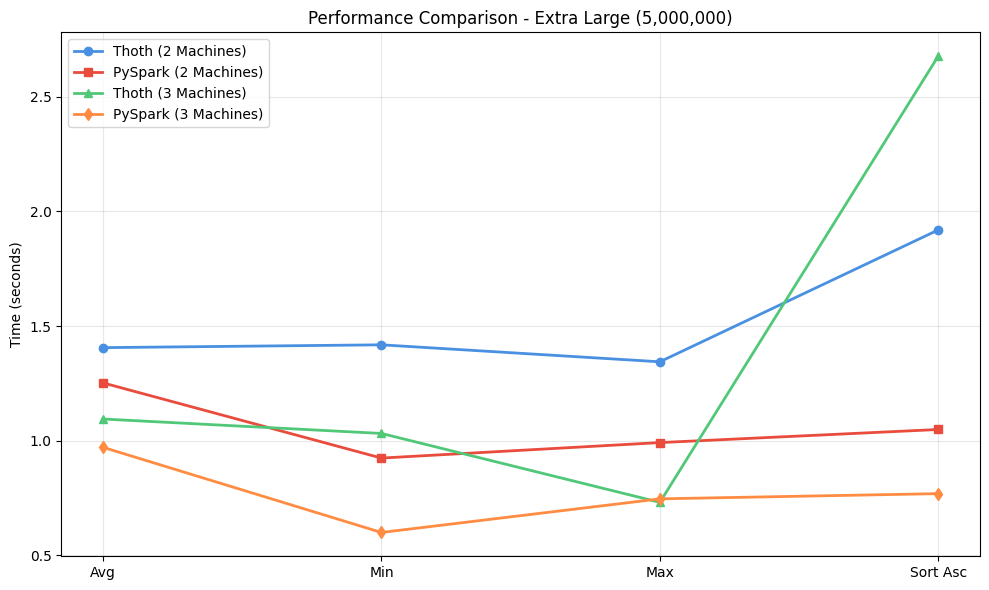

IndexError: single positional indexer is out-of-bounds

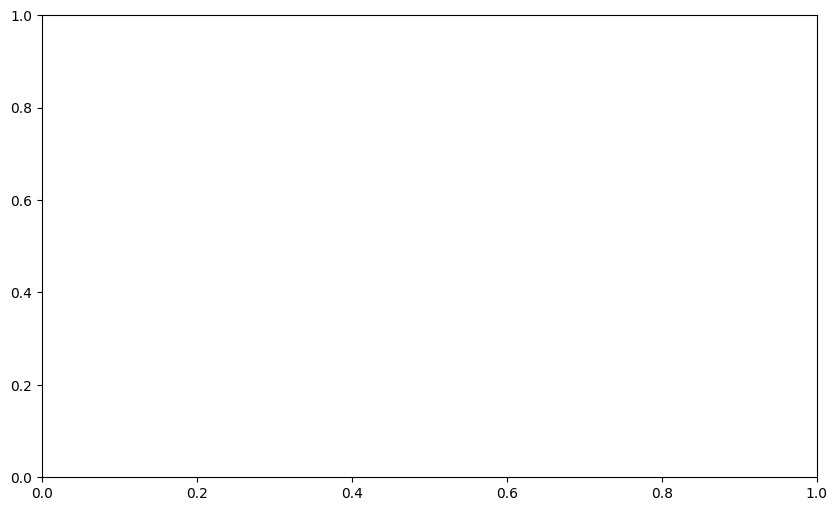

In [ ]:
def plot_combined_comparison(two_machines_df, three_machines_df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    datasets = two_machines_df["Dataset"]
    operations = ["Avg", "Min", "Max", "Sort Asc"]
    
    for i, dataset in enumerate(datasets):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Extract data for this dataset
        thoth_2m = [
            two_machines_df.iloc[i]["Thoth Avg Time (s)"],
            two_machines_df.iloc[i]["Thoth Min Time (s)"],
            two_machines_df.iloc[i]["Thoth Max Time (s)"],
            two_machines_df.iloc[i]["Thoth Sort Asc Time (s)"]
        ]
        
        pyspark_2m = [
            two_machines_df.iloc[i]["PySpark Avg Time (s)"],
            two_machines_df.iloc[i]["PySpark Min Time (s)"],
            two_machines_df.iloc[i]["PySpark Max Time (s)"],
            two_machines_df.iloc[i]["PySpark Sort Asc Time (s)"]
        ]
        
        thoth_3m = [
            three_machines_df.iloc[i]["Thoth Avg Time (s)"],
            three_machines_df.iloc[i]["Thoth Min Time (s)"],
            three_machines_df.iloc[i]["Thoth Max Time (s)"],
            three_machines_df.iloc[i]["Thoth Sort Asc Time (s)"]
        ]
        
        pyspark_3m = [
            three_machines_df.iloc[i]["PySpark Avg Time (s)"],
            three_machines_df.iloc[i]["PySpark Min Time (s)"],
            three_machines_df.iloc[i]["PySpark Max Time (s)"],
            three_machines_df.iloc[i]["PySpark Sort Asc Time (s)"]
        ]
        
        x = np.arange(len(operations))
        
        ax.plot(x, thoth_2m, marker='o', linewidth=2, label='Thoth (2 Machines)', color='#4A90E2')
        ax.plot(x, pyspark_2m, marker='s', linewidth=2, label='PySpark (2 Machines)', color='#E94B3C')
        ax.plot(x, thoth_3m, marker='^', linewidth=2, label='Thoth (3 Machines)', color='#50C878')
        ax.plot(x, pyspark_3m, marker='d', linewidth=2, label='PySpark (3 Machines)', color='#FF8C42')
        
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Performance Comparison - {dataset}')
        ax.set_xticks(x)
        ax.set_xticklabels(operations)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        dataset_name = dataset.split()[0].lower()
        plt.savefig(os.path.join(output_dir, f"combined_comparison_{dataset_name}.png"))
        plt.show()

plot_combined_comparison(two_machines_df, three_machines_df, os.path.join(OUTPUT_DIR, "combined"))